# Homework 2 - 2.2

In this assignment I will be using pytorch to conduct the experiments for this homework assignment

In [1]:
## First step in the assignment was to install pytorch with the CPU only version since my laptop is not CUDA enabled.

##Tutorial that was followed for this homework assignment was: https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

#conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [11]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [40]:
# Getting all the MNIST files from pytorch
part_tr = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
part_te = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

# tr_split_len = 6000
# te_split_len = 1000

# part_tr = torch.utils.data.random_split(train_data, [tr_split_len, len(train_data)-tr_split_len])[0]
# part_te = torch.utils.data.random_split(test_data, [te_split_len, len(test_data)-te_split_len])[0]

In [41]:
loaders = {
    'train' : torch.utils.data.DataLoader(part_tr, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(part_te, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x20d43d4f2e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x20d43d4fb80>}

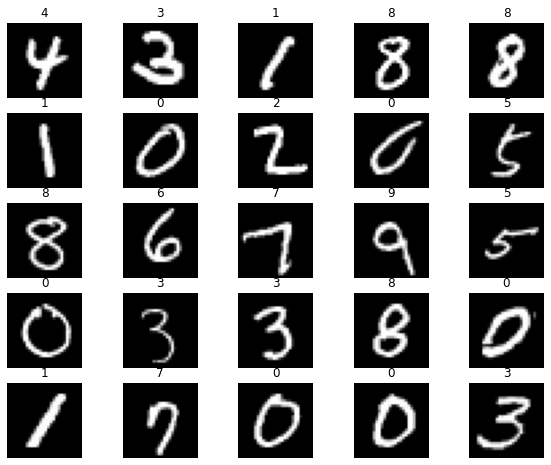

In [42]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Base CNN Model

In [43]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 3, 1, 0),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 5 * 5, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    


In [44]:
#View of the CNN
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=800, out_features=10, bias=True)
)


In [45]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [46]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [83]:
from torch.autograd import Variable

num_epochs = 10

#_____________________________

loss_list = []
iteration_list = []
accuracy_list = []
count = 0
start_time = time.time()

cnn.train()

# Train the model
total_step = len(loaders['train'])
print(total_step)

for epoch in range(num_epochs):
#         print("here at each epoch")

    for i, (images, labels) in enumerate(loaders['train']):



        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y

        output = cnn(b_x)[0]               
        loss = loss_func(output, b_y)

        # clear gradients for this training step   
        optimizer.zero_grad()           
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()  

        count = count + 1

        if (i+1) % 60 == 0:
            correct = 0
            total = 0
            for images, labels in loaders['test']:
                test_output, last_layer = cnn(images)
                predicted = torch.max(test_output, 1)[1].data.squeeze()
                correct += (predicted == labels).sum().item()
                total += float(labels.size(0))
                              
            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        pass
    pass




600
Epoch [1/10], Step [60/600], Loss: 0.0133
Epoch [1/10], Step [120/600], Loss: 0.0000
Epoch [1/10], Step [180/600], Loss: 0.0308
Epoch [1/10], Step [240/600], Loss: 0.0262
Epoch [1/10], Step [300/600], Loss: 0.0118
Epoch [1/10], Step [360/600], Loss: 0.0201
Epoch [1/10], Step [420/600], Loss: 0.1643
Epoch [1/10], Step [480/600], Loss: 0.0038
Epoch [1/10], Step [540/600], Loss: 0.0389
Epoch [1/10], Step [600/600], Loss: 0.0195
Epoch [2/10], Step [60/600], Loss: 0.0171
Epoch [2/10], Step [120/600], Loss: 0.0506
Epoch [2/10], Step [180/600], Loss: 0.0110
Epoch [2/10], Step [240/600], Loss: 0.0145
Epoch [2/10], Step [300/600], Loss: 0.0646
Epoch [2/10], Step [360/600], Loss: 0.0023
Epoch [2/10], Step [420/600], Loss: 0.0236
Epoch [2/10], Step [480/600], Loss: 0.0323
Epoch [2/10], Step [540/600], Loss: 0.0001
Epoch [2/10], Step [600/600], Loss: 0.0003
Epoch [3/10], Step [60/600], Loss: 0.0001
Epoch [3/10], Step [120/600], Loss: 0.0280
Epoch [3/10], Step [180/600], Loss: 0.0723
Epoch [3/1

In [87]:
after_time = time.time()

total_time = after_time - start_time
print("Total Training Time")
print(total_time)

Total Training Time
619.4636640548706


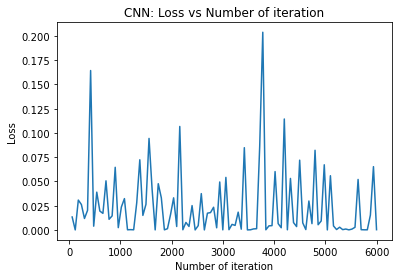

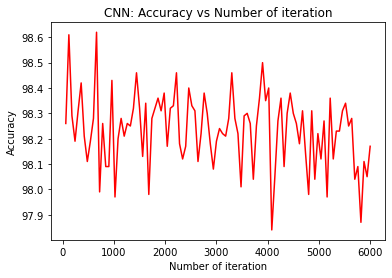

In [89]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [88]:
test_start_time = time.time()

def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        pass
test()

test_end_time = time.time()
total_test_time = test_end_time - test_start_time
print("Total Testing Time")
print(total_test_time)

Test Accuracy of the model on the 10000 test images: 0.99
Total Testing Time
5.7873218059539795


## 1. CNN with Hyperparameter (kernal - 5 and optimizer - Adam and learning rate - 0.005)

In [95]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
#View of the CNN
cnn = CNN()
print(cnn)

loss_func = nn.CrossEntropyLoss()   
loss_func

from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

# torch.optim.SGD(model.parameters(), lr=learning_rate)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [96]:
from torch.autograd import Variable

num_epochs = 10

#_____________________________

loss_list = []
iteration_list = []
accuracy_list = []
count = 0
start_time = time.time()

cnn.train()

# Train the model
total_step = len(loaders['train'])
print(total_step)

for epoch in range(num_epochs):
#         print("here at each epoch")

    for i, (images, labels) in enumerate(loaders['train']):



        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y

        output = cnn(b_x)[0]               
        loss = loss_func(output, b_y)

        # clear gradients for this training step   
        optimizer.zero_grad()           
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()  

        count = count + 1

        if (i+1) % 60 == 0:
            correct = 0
            total = 0
            for images, labels in loaders['test']:
                test_output, last_layer = cnn(images)
                predicted = torch.max(test_output, 1)[1].data.squeeze()
                correct += (predicted == labels).sum().item()
                total += float(labels.size(0))
                              
            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        pass
    pass


600
Epoch [1/10], Step [60/600], Loss: 0.2471
Epoch [1/10], Step [120/600], Loss: 0.0657
Epoch [1/10], Step [180/600], Loss: 0.0726
Epoch [1/10], Step [240/600], Loss: 0.0502
Epoch [1/10], Step [300/600], Loss: 0.1454
Epoch [1/10], Step [360/600], Loss: 0.0743
Epoch [1/10], Step [420/600], Loss: 0.0810
Epoch [1/10], Step [480/600], Loss: 0.0116
Epoch [1/10], Step [540/600], Loss: 0.0200
Epoch [1/10], Step [600/600], Loss: 0.0188
Epoch [2/10], Step [60/600], Loss: 0.0189
Epoch [2/10], Step [120/600], Loss: 0.0179
Epoch [2/10], Step [180/600], Loss: 0.0492
Epoch [2/10], Step [240/600], Loss: 0.0116
Epoch [2/10], Step [300/600], Loss: 0.0156
Epoch [2/10], Step [360/600], Loss: 0.0049
Epoch [2/10], Step [420/600], Loss: 0.0388
Epoch [2/10], Step [480/600], Loss: 0.0525
Epoch [2/10], Step [540/600], Loss: 0.0100
Epoch [2/10], Step [600/600], Loss: 0.0352
Epoch [3/10], Step [60/600], Loss: 0.1428
Epoch [3/10], Step [120/600], Loss: 0.0096
Epoch [3/10], Step [180/600], Loss: 0.0109
Epoch [3/1

In [97]:
after_time = time.time()

total_time = after_time - start_time
print("Total Training Time")
print(total_time)

Total Training Time
1154.0441348552704


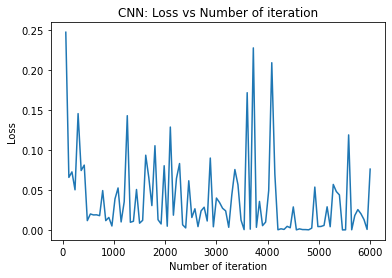

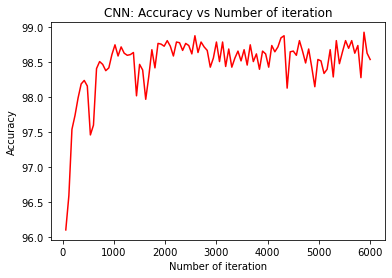

In [98]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [99]:
test_start_time = time.time()

def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        pass
test()

test_end_time = time.time()
total_test_time = test_end_time - test_start_time
print("Total Testing Time")
print(total_test_time)

Test Accuracy of the model on the 10000 test images: 0.98
Total Testing Time
4.410999298095703


## 2. CNN with Hyperparameter (kernal - 5 and optimizer - SGD and learning rate - 0.005)

In [100]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
#View of the CNN
cnn = CNN()
print(cnn)

loss_func = nn.CrossEntropyLoss()   
loss_func

from torch import optim
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)   
optimizer

# torch.optim.SGD(model.parameters(), lr=learning_rate)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [101]:
from torch.autograd import Variable

num_epochs = 10

#_____________________________

loss_list = []
iteration_list = []
accuracy_list = []
count = 0
start_time = time.time()

cnn.train()

# Train the model
total_step = len(loaders['train'])
print(total_step)

for epoch in range(num_epochs):
#         print("here at each epoch")

    for i, (images, labels) in enumerate(loaders['train']):



        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y

        output = cnn(b_x)[0]               
        loss = loss_func(output, b_y)

        # clear gradients for this training step   
        optimizer.zero_grad()           
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()  

        count = count + 1

        if (i+1) % 60 == 0:
            correct = 0
            total = 0
            for images, labels in loaders['test']:
                test_output, last_layer = cnn(images)
                predicted = torch.max(test_output, 1)[1].data.squeeze()
                correct += (predicted == labels).sum().item()
                total += float(labels.size(0))
                              
            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        pass
    pass




600
Epoch [1/10], Step [60/600], Loss: 2.2744
Epoch [1/10], Step [120/600], Loss: 2.2426
Epoch [1/10], Step [180/600], Loss: 2.0945
Epoch [1/10], Step [240/600], Loss: 1.7018
Epoch [1/10], Step [300/600], Loss: 0.8306
Epoch [1/10], Step [360/600], Loss: 0.6454
Epoch [1/10], Step [420/600], Loss: 0.4880
Epoch [1/10], Step [480/600], Loss: 0.4291
Epoch [1/10], Step [540/600], Loss: 0.4240
Epoch [1/10], Step [600/600], Loss: 0.3868
Epoch [2/10], Step [60/600], Loss: 0.4078
Epoch [2/10], Step [120/600], Loss: 0.4814
Epoch [2/10], Step [180/600], Loss: 0.3012
Epoch [2/10], Step [240/600], Loss: 0.2618
Epoch [2/10], Step [300/600], Loss: 0.2431
Epoch [2/10], Step [360/600], Loss: 0.2720
Epoch [2/10], Step [420/600], Loss: 0.2842
Epoch [2/10], Step [480/600], Loss: 0.3936
Epoch [2/10], Step [540/600], Loss: 0.4434
Epoch [2/10], Step [600/600], Loss: 0.1639
Epoch [3/10], Step [60/600], Loss: 0.3047
Epoch [3/10], Step [120/600], Loss: 0.2986
Epoch [3/10], Step [180/600], Loss: 0.1924
Epoch [3/1

In [102]:
after_time = time.time()

total_time = after_time - start_time
print("Total Training Time")
print(total_time)

Total Training Time
875.5351192951202


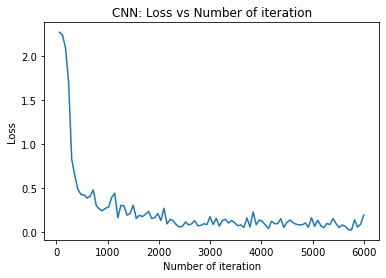

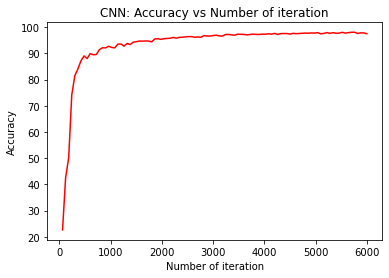

In [103]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [104]:
test_start_time = time.time()

def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        pass
test()

test_end_time = time.time()
total_test_time = test_end_time - test_start_time
print("Total Testing Time")
print(total_test_time)

Test Accuracy of the model on the 10000 test images: 0.98
Total Testing Time
4.3966450691223145


## 3. CNN with Hyperparameter (kernal - 3 and optimizer - Adam and learning rate - 0.005)

In [105]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 3, 1, 0),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 5 * 5, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
#View of the CNN
cnn = CNN()
print(cnn)

loss_func = nn.CrossEntropyLoss()   
loss_func

from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

# torch.optim.SGD(model.parameters(), lr=learning_rate)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=800, out_features=10, bias=True)
)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [106]:
from torch.autograd import Variable

num_epochs = 10

#_____________________________

loss_list = []
iteration_list = []
accuracy_list = []
count = 0
start_time = time.time()

cnn.train()

# Train the model
total_step = len(loaders['train'])
print(total_step)

for epoch in range(num_epochs):
#         print("here at each epoch")

    for i, (images, labels) in enumerate(loaders['train']):



        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y

        output = cnn(b_x)[0]               
        loss = loss_func(output, b_y)

        # clear gradients for this training step   
        optimizer.zero_grad()           
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()  

        count = count + 1

        if (i+1) % 60 == 0:
            correct = 0
            total = 0
            for images, labels in loaders['test']:
                test_output, last_layer = cnn(images)
                predicted = torch.max(test_output, 1)[1].data.squeeze()
                correct += (predicted == labels).sum().item()
                total += float(labels.size(0))
                              
            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        pass
    pass




600
Epoch [1/10], Step [60/600], Loss: 0.1710
Epoch [1/10], Step [120/600], Loss: 0.0666
Epoch [1/10], Step [180/600], Loss: 0.1969
Epoch [1/10], Step [240/600], Loss: 0.1609
Epoch [1/10], Step [300/600], Loss: 0.1492
Epoch [1/10], Step [360/600], Loss: 0.0722
Epoch [1/10], Step [420/600], Loss: 0.1612
Epoch [1/10], Step [480/600], Loss: 0.1066
Epoch [1/10], Step [540/600], Loss: 0.1331
Epoch [1/10], Step [600/600], Loss: 0.0905
Epoch [2/10], Step [60/600], Loss: 0.0199
Epoch [2/10], Step [120/600], Loss: 0.1037
Epoch [2/10], Step [180/600], Loss: 0.0724
Epoch [2/10], Step [240/600], Loss: 0.0353
Epoch [2/10], Step [300/600], Loss: 0.0135
Epoch [2/10], Step [360/600], Loss: 0.0724
Epoch [2/10], Step [420/600], Loss: 0.0691
Epoch [2/10], Step [480/600], Loss: 0.0099
Epoch [2/10], Step [540/600], Loss: 0.0076
Epoch [2/10], Step [600/600], Loss: 0.0497
Epoch [3/10], Step [60/600], Loss: 0.0230
Epoch [3/10], Step [120/600], Loss: 0.1325
Epoch [3/10], Step [180/600], Loss: 0.0351
Epoch [3/1

In [107]:
after_time = time.time()

total_time = after_time - start_time
print("Total Training Time")
print(total_time)

Total Training Time
726.0485565662384


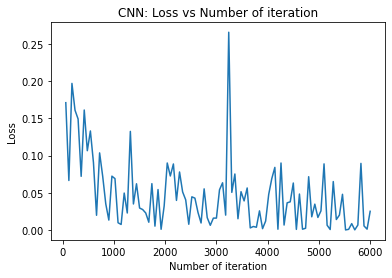

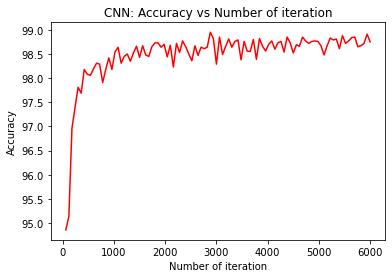

In [108]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [109]:
test_start_time = time.time()

def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        pass
test()

test_end_time = time.time()
total_test_time = test_end_time - test_start_time
print("Total Testing Time")
print(total_test_time)

Test Accuracy of the model on the 10000 test images: 0.99
Total Testing Time
4.16533088684082


## 4. CNN with Hyperparameter (kernal - 3 and optimizer - SGD and learning rate - 0.005)

In [110]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 3, 1, 0),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 5 * 5, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
#View of the CNN
cnn = CNN()
print(cnn)

loss_func = nn.CrossEntropyLoss()   
loss_func

from torch import optim
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)  
optimizer

# torch.optim.SGD(model.parameters(), lr=learning_rate)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=800, out_features=10, bias=True)
)


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [111]:
from torch.autograd import Variable

num_epochs = 10

#_____________________________

loss_list = []
iteration_list = []
accuracy_list = []
count = 0
start_time = time.time()

cnn.train()

# Train the model
total_step = len(loaders['train'])
print(total_step)

for epoch in range(num_epochs):
#         print("here at each epoch")

    for i, (images, labels) in enumerate(loaders['train']):



        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y

        output = cnn(b_x)[0]               
        loss = loss_func(output, b_y)

        # clear gradients for this training step   
        optimizer.zero_grad()           
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()  

        count = count + 1

        if (i+1) % 60 == 0:
            correct = 0
            total = 0
            for images, labels in loaders['test']:
                test_output, last_layer = cnn(images)
                predicted = torch.max(test_output, 1)[1].data.squeeze()
                correct += (predicted == labels).sum().item()
                total += float(labels.size(0))
                              
            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        pass
    pass




600
Epoch [1/10], Step [60/600], Loss: 2.1958
Epoch [1/10], Step [120/600], Loss: 1.9312
Epoch [1/10], Step [180/600], Loss: 1.2465
Epoch [1/10], Step [240/600], Loss: 0.7441
Epoch [1/10], Step [300/600], Loss: 0.6112
Epoch [1/10], Step [360/600], Loss: 0.3333
Epoch [1/10], Step [420/600], Loss: 0.4473
Epoch [1/10], Step [480/600], Loss: 0.4879
Epoch [1/10], Step [540/600], Loss: 0.5323
Epoch [1/10], Step [600/600], Loss: 0.3376
Epoch [2/10], Step [60/600], Loss: 0.2650
Epoch [2/10], Step [120/600], Loss: 0.3086
Epoch [2/10], Step [180/600], Loss: 0.3694
Epoch [2/10], Step [240/600], Loss: 0.5400
Epoch [2/10], Step [300/600], Loss: 0.3169
Epoch [2/10], Step [360/600], Loss: 0.1987
Epoch [2/10], Step [420/600], Loss: 0.3798
Epoch [2/10], Step [480/600], Loss: 0.2280
Epoch [2/10], Step [540/600], Loss: 0.4555
Epoch [2/10], Step [600/600], Loss: 0.1609
Epoch [3/10], Step [60/600], Loss: 0.2723
Epoch [3/10], Step [120/600], Loss: 0.2301
Epoch [3/10], Step [180/600], Loss: 0.3830
Epoch [3/1

In [112]:
after_time = time.time()

total_time = after_time - start_time
print("Total Training Time")
print(total_time)

Total Training Time
714.0182099342346


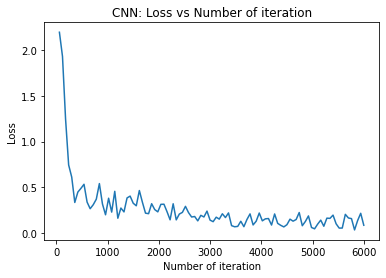

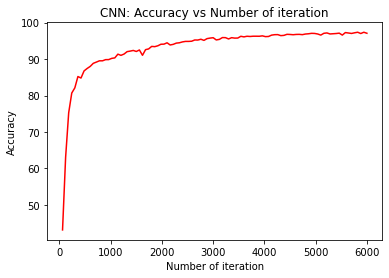

In [113]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [114]:
test_start_time = time.time()

def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        pass
test()

test_end_time = time.time()
total_test_time = test_end_time - test_start_time
print("Total Testing Time")
print(total_test_time)

Test Accuracy of the model on the 10000 test images: 0.97
Total Testing Time
4.092662334442139


## End of Experiments

In [52]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [53]:
actual_number = lbls[:10].numpy()
actual_number

array([4, 7, 1, 1, 1, 0, 3, 5, 4, 2], dtype=int64)

In [54]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [4 7 1 1 1 0 3 5 4 2]
Actual number: [4 7 1 1 1 0 3 5 4 2]


In [ ]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [ ]:
#Definition of hyperparameters
n_iters = 10
num_epochs = n_iters / (len(train_x) / batch_size)
num_epochs = int(num_epochs)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                # Forward propagation
                outputs = model(test)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

In [ ]:
# Other optimizers
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

test